# **Text Classification Model Training**

#### Imports

In [1]:
import os
import json
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
# from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore

2024-08-26 13:33:28.965412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 13:33:28.979609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 13:33:28.984125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 13:33:28.996540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 13:33:30.029291: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", (tf.config.list_physical_devices()))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1724659410.733065   17898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724659410.756937   17898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724659410.759794   17898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
dataset_folder = '../data/text/'
training_folder = 'training/'
testing_folder = 'validation/'
sensitive_data = 'SensitiveDataset.json'
nonsensitive_data = 'NonSensitiveDataset.json'

In [4]:
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type = 'post'
padding_type = 'post'
oov_tokens = "<OOV>"
training_size = 20000

## Data Preprocessing

In [5]:
data_list = []
sentences = []
labels = []

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are",
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but",
             "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from",
             "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's",
             "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if",
             "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor",
             "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own",
             "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's",
             "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd",
             "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's",
             "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you",
             "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]

In [6]:
def load_dataset(filename):
    with open(dataset_folder + training_folder + filename, 'r') as f:
        datastore = json.load(f)

    for item in datastore:
        sentence = item['data']
        label = item['is_sensitive']
        for word in stopwords: # Removing stop words in sentence
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            data_list.append([sentence, label])

load_dataset(sensitive_data)
load_dataset(nonsensitive_data)

In [7]:
random.shuffle(data_list)
print("Dataset Size: ", len(data_list))

Dataset Size:  4831128


In [8]:
for item in data_list:
  sentences.append(item[0])
  labels.append(item[1])

In [9]:
training_sentences = sentences[0:training_size]
training_labels = labels[0:training_size]
validation_sentences = sentences[training_size:1500000]
validation_labels = labels[training_size:1500000]

In [10]:
print("*"*100)
print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:\n", training_sentences[0])
print("*"*100)
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:\n", validation_sentences[0])
print("*"*100)

****************************************************************************************************
Training Dataset Size:  20000
Sample Training Data:
 card no:7128 7034 7084 5885, expiry month:nov-22, card holder name:vasantha  saivarajan, cvv:644
****************************************************************************************************
Validation Dataset Size:  1480000
Sample Validation Data:
 username:grissel, password:nigga1, email:grissel@rambler.ru, phone no:632734840
****************************************************************************************************


In [11]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tokens)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))
os.makedirs('../models', exist_ok=True)
with open("../models/word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                # padding=padding_type, truncating=truncation_type
                                )

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, 
                                #   padding=padding_type, truncating=truncation_type
                                  )

Size of word index: 87942
Saving the word index as JSON


In [12]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

## Model

In [13]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    # Global average pooling operation (Flattening)
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(12, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

I0000 00:00:1724659532.860315   17898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724659532.863357   17898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724659532.865907   17898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724659532.974913   17898 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

In [14]:
num_epochs = 10

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/10


I0000 00:00:1724659533.787228   19421 service.cc:146] XLA service 0x7f026c015f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724659533.787283   19421 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-08-26 13:35:33.805074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-26 13:35:33.909712: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


197/625 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.9437 - loss: 0.2674

I0000 00:00:1724659534.836246   19421 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9713 - loss: 0.1367 - val_accuracy: 0.9983 - val_loss: 0.0060
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9989 - loss: 0.0047 - val_accuracy: 0.9997 - val_loss: 0.0018
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9997 - val_loss: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 1.0000 - loss: 3.5610e-04 - val_accuracy: 0.9999 - val_loss: 6.6297e-04
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 1.0000 - loss: 1.8755e-04 - val_accuracy: 0.9999 - val_loss: 5.2113e-04
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 1.0000 - loss: 1.3921e-04 - val_accuracy: 0.9999 - val_loss: 4.9986e-04
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 1.0000 - lo

## Visualising Accuracy and Loss Functions

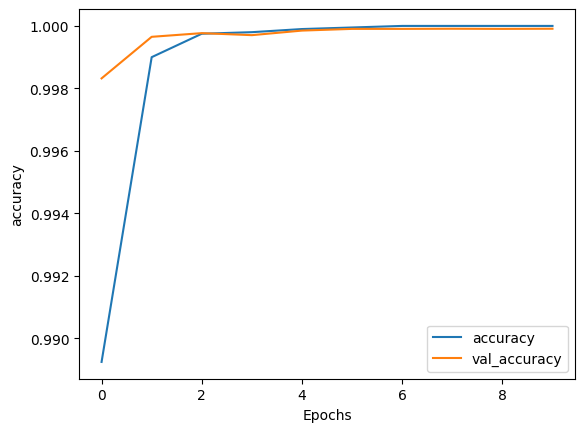

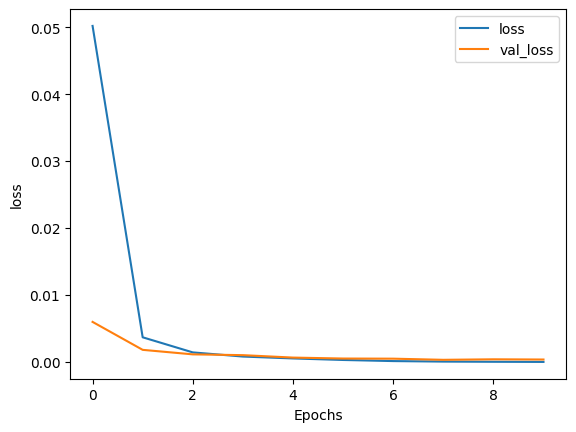

In [15]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix

Confusion Matrix
46250/46250 ━━━━━━━━━━━━━━━━━━━━ 21s 444us/step
Accuracy for 370000 Test Data =  99.9927027027027
Accuracy for 740000 Test Data =  99.9914864864865
Accuracy for 1110000 Test Data =  99.99072072072072
Accuracy for 1480000 Test Data =  99.99101351351352


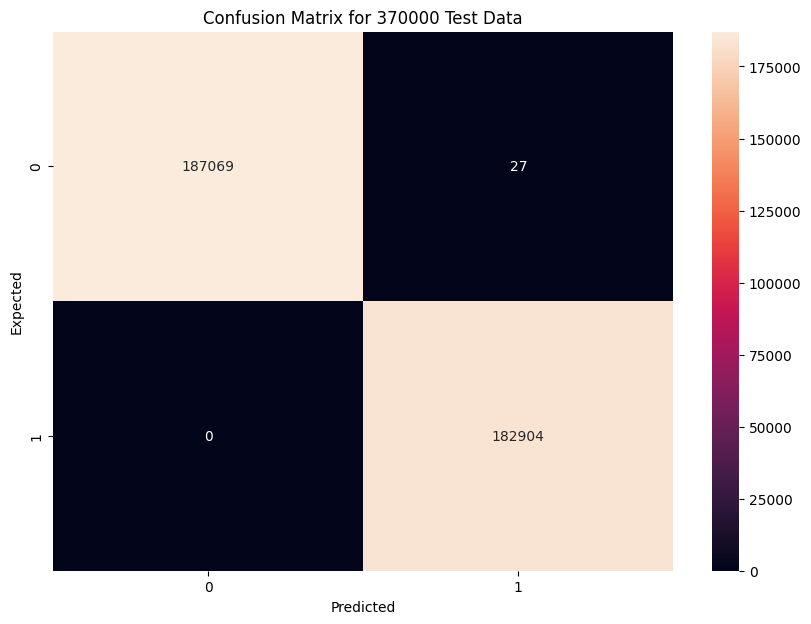

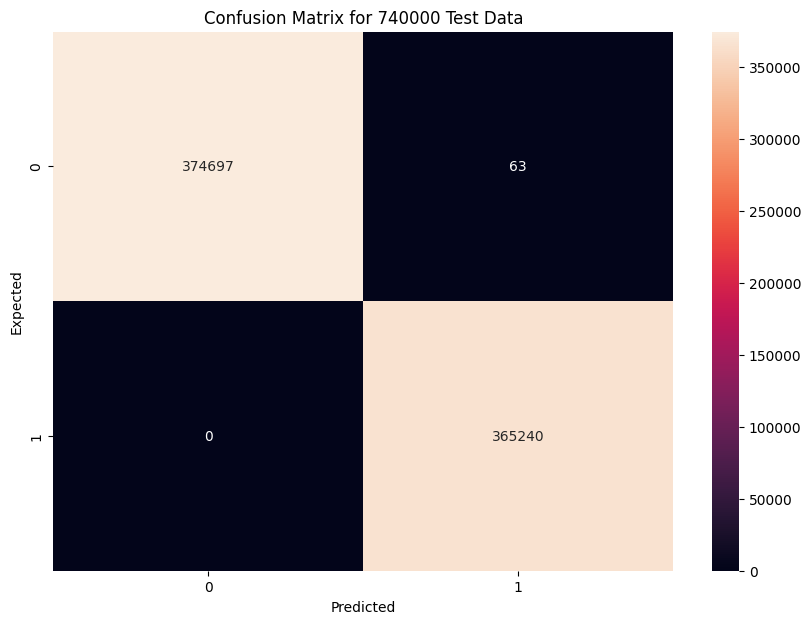

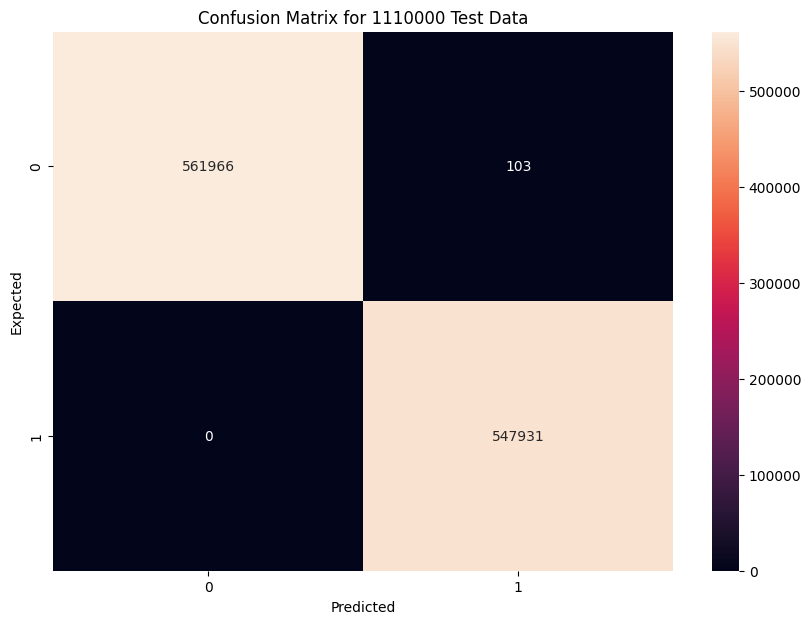

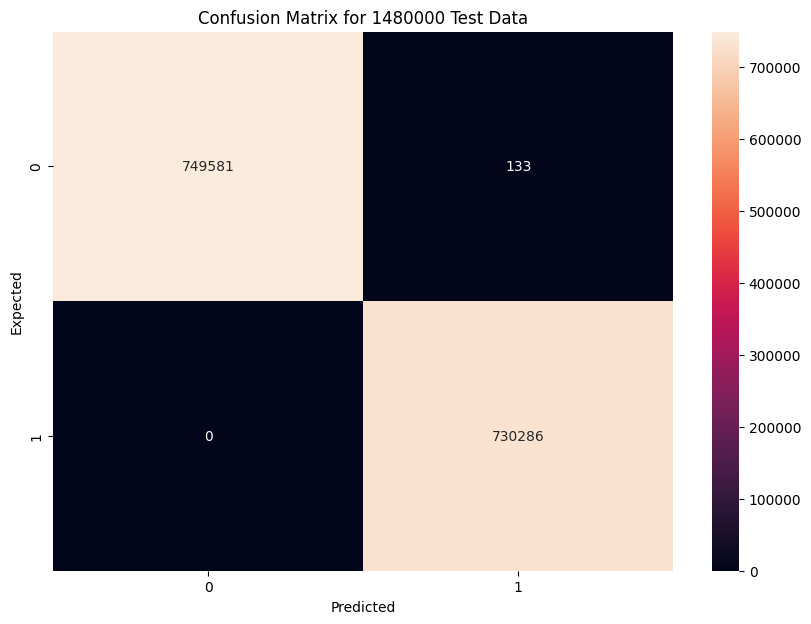

In [16]:
import seaborn
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
y_predicted_labels = y_predicted > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

## Locally saving the Model

In [17]:
model.save('../models/text_model.h5')
print("Saved the model successfully")

Saved the model successfully


In [18]:
!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/models/text_model.h5 /content/text_model
print("Model converted to JSON successfully")

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
created virtual environment CPython3.11.9.final.0-64 in 139ms
  creator CPython3Posix(dest=/home/kali/Desktop/redact-sih/notebooks/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/kali/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==70.3.0, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
2024-08-26 13:39:44.386840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 13:39:44.399096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to regist

## Testing the Model

In [19]:
sentence = ["My credit card no is 124345346", 
            "game of thrones season finale showing this sunday night",
            ]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  if predictions[i][0]>0.5:
    print("Sensitive - "+ sentence[i])
  else:
    print("Non-Sensitive - " + sentence[i] )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
0.99906
Sensitive - My credit card no is 124345346
0.9120853
Sensitive - game of thrones season finale showing this sunday night
